In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
import glob
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')


In [346]:
# Read in stress csv files at x=-450000

sims = ['Flux100Sigma4000', 'Flux100Sigma8000', 'Flux100Sigma16000', 'Flux200Sigma4000',  \
        'Flux200Sigma8000', 'Flux300Sigma4000', 'Flux300Sigma8000',  'Flux300Sigma12000', \
        'Flux400Sigma4000', 'Flux400Sigma8000', 'Flux500Sigma4000',  'Flux500Sigma8000',  \
        'Flux500Sigma12000']
dfs = {}
for sim in sims:
    dfs[sim] = pd.read_csv('../Data/Stress/' + str(sim) + 'm45000.csv')


In [347]:
# Re-order data by the y-coordinate and the z-coordinate

for sim in sims:
    dfs[sim] = dfs[sim].sort_values(by=['Points:1', 'Points:2'])
    dfs[sim] = dfs[sim].reset_index(drop=True)
    

In [348]:
# Create dataframe column for the deviatoric stresses

for sim in sims:
    for i in range(1, 4):
        dfs[sim]['dev stress ' + str(i)] = dfs[sim]['stress ' + str(i)] + dfs[sim]['pressure']


In [349]:
# Find y-coordinates where there are not 10 nodes and remove these rows from the dataframe

for sim in sims:
    count = 0
    ycoord_outliers = []
    for i in range(1, len(dfs[sim])):
        ycoord = dfs[sim]['Points:1'][i]
        if ycoord == dfs[sim]['Points:1'][i-1]:
            count += 1
        else:
            if count != 9:
                ycoord_outliers.append(dfs[sim]['Points:1'][i-1])
            count = 0
    dfs[sim] = dfs[sim][~dfs[sim]['Points:1'].isin(ycoord_outliers)]
    dfs[sim] = dfs[sim].reset_index(drop=True)


In [350]:
# Calculate depth averaged stress

depth_averaged_dfs = {}
ycoords = list(dict.fromkeys(dfs['Flux100Sigma4000']['Points:1']))
depth_averaged_dfs['Flux100Sigma4000'] = pd.DataFrame(ycoords, columns=['Points:1'])
depth_averaged_dfs['Flux100Sigma4000']['depth avg. dev stress 1'] = [0] * len(depth_averaged_dfs['Flux100Sigma4000'])

for i in range(len(dfs['Flux100Sigma4000'])):
    if dfs['Flux100Sigma4000']['height'][i] == 0.0 or dfs['Flux100Sigma4000']['depth'][i] == 0.0: 
        depth_averaged_dfs['Flux100Sigma4000']['depth avg. dev stress 1'][i % len(ycoords)] += 0.5 * dfs['Flux100Sigma4000']['dev stress 1'][i]
    else:
        depth_averaged_dfs['Flux100Sigma4000']['depth avg. dev stress 1'][i % len(ycoords)] += dfs['Flux100Sigma4000']['dev stress 1'][i]
        
depth_averaged_dfs['Flux100Sigma4000']['depth avg. dev stress 1'] = depth_averaged_dfs['Flux100Sigma4000']['depth avg. dev stress 1'] / 9.0

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_53328/4012706333.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  depth_averaged_dfs['Flux100Sigma4000']['depth avg. dev stress 1'][i % len(ycoords)] += 0.5 * dfs['Flux100Sigma4000']['dev stress 1'][i]


In [351]:
depth_averaged_dfs['Flux100Sigma4000']

,Points:1,depth avg. dev stress 1
0,-75000.0,0.024938
1,-74915.0,0.033249
2,-73210.0,0.033251
3,-71863.0,0.033239
4,-71535.0,0.033252
...,...,...
160,71547.0,0.024829
161,71985.0,0.033140
162,73252.0,0.033141
163,74604.0,0.033164


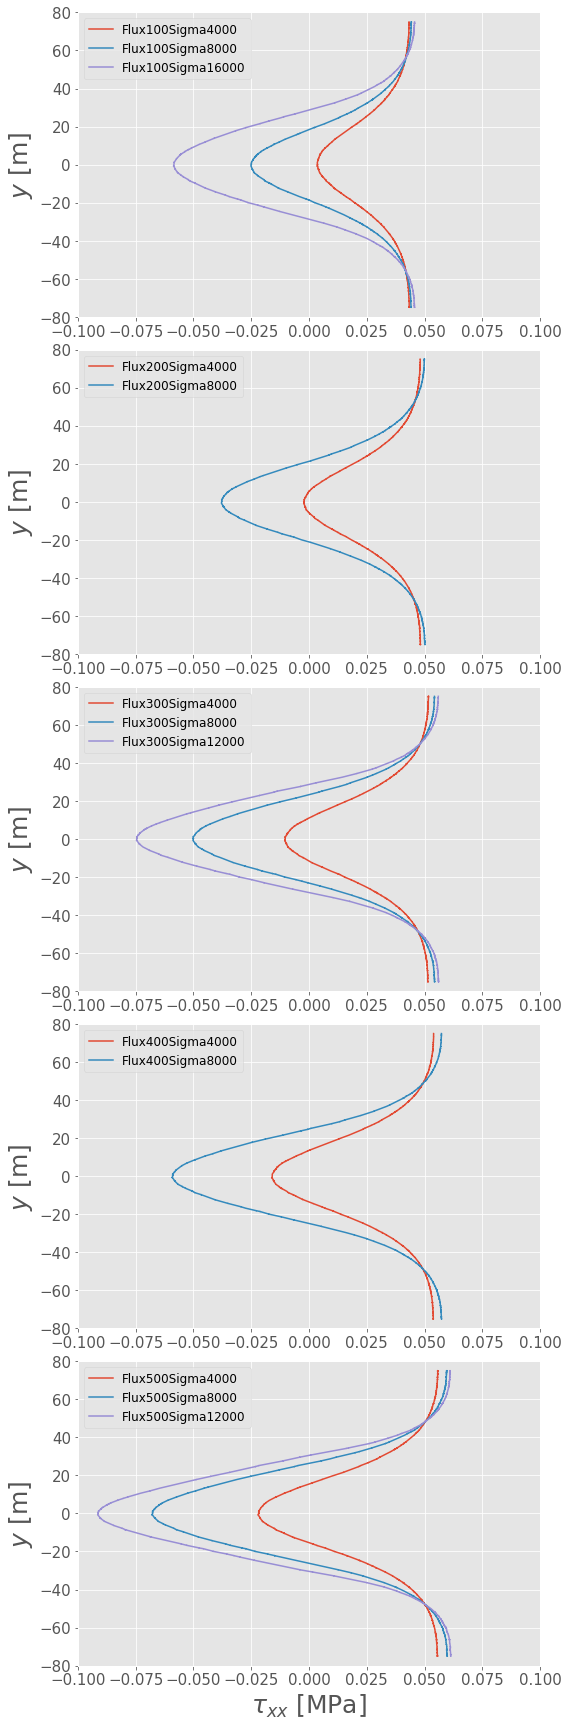

In [352]:
# Plot 

fig, ax = plt.subplots(5, 1, figsize=(8, 24))
for i in range(0, 3):
    ax[0].plot(dfs[sims[i]]['dev stress 1'], dfs[sims[i]]['Points:1']/1000, label=sims[i])
for i in range(3, 5):
    ax[1].plot(dfs[sims[i]]['dev stress 1'], dfs[sims[i]]['Points:1']/1000, label=sims[i])
for i in range(5, 8):
    ax[2].plot(dfs[sims[i]]['dev stress 1'], dfs[sims[i]]['Points:1']/1000, label=sims[i])
for i in range(8, 10):
    ax[3].plot(dfs[sims[i]]['dev stress 1'], dfs[sims[i]]['Points:1']/1000, label=sims[i])
for i in range(10, 13):
    ax[4].plot(dfs[sims[i]]['dev stress 1'], dfs[sims[i]]['Points:1']/1000, label=sims[i])
for i in range(5):
    ax[i].set_xlim([-0.1, 0.1])
    ax[i].set_ylim([-80, 80])
    ax[i].set_ylabel(r'$y$ [m]', size=25)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(fontsize='12')
ax[4].set_xlabel(r'$\tau_{xx}$ [MPa]', size=25)
#ax[0].title.set_text(r'Flux $=100$ [m a$^{-1}$]')
#ax[1].title.set_text(r'Flux $=200$ [m a$^{-1}$]')
#ax[2].title.set_text(r'Flux $=300$ [m a$^{-1}$]')
#ax[3].title.set_text(r'Flux $=400$ [m a$^{-1}$]')
#ax[4].title.set_text(r'Flux $=500$ [m a$^{-1}$]')
fig.tight_layout()
